# Hands-on tutorial for Nirdizati light

# Prepare environment

In [1]:
# Import required modules
import os
import random
import numpy as np

import pandas as pd
import pm4py

from nirdizati_light.log.common import get_log, split_train_val_test
from nirdizati_light.encoding.common import get_encoded_df, EncodingType
from nirdizati_light.encoding.constants import TaskGenerationType, PrefixLengthStrategy, EncodingTypeAttribute
from nirdizati_light.encoding.time_encoding import TimeEncodingType
from nirdizati_light.labeling.common import LabelTypes
from nirdizati_light.predictive_model.common import ClassificationMethods
from nirdizati_light.predictive_model.predictive_model import PredictiveModel
from nirdizati_light.hyperparameter_optimisation.common import retrieve_best_model, HyperoptTarget
from nirdizati_light.evaluation.common import evaluate_classifier, evaluate_classifiers, plot_model_comparison
from nirdizati_light.explanation.common import ExplainerType, explain

# Configure pipeline parameters

# Setting up the CONF dictionary
## Configuration Parameters for Process Mining in LaTeX

Below is the configuration dictionary `CONF` formatted in LaTeX. Each parameter is explained in detail.
The dictionary is the main objectives of the Nirdizati\_light framework. It specifies all required parameters to use when training multiple predictive model(s) for a given configuration, ranging from the train-test-val split ratio to the prefix lengths to be used and encodings to be used by the model.

---


## Configuration Dictionary: CONF


### **Paths**

\begin{aligned}
\textbf{data:} & \quad \text{'../datasets/bpic2012\_O\_ACCEPTED-COMPLETE/full.xes'} \quad \text{// Path to the dataset file.} \\
\textbf{output:} & \quad \text{'output\_data'} \quad \text{// Path to the directory where output data is saved.} \\
\end{aligned}


---

### **Dataset Splitting**
\begin{align*}
\textbf{train\_val\_test\_split:} & \quad [0.7, 0.1, 0.2] \quad \text{// Proportions for splitting the dataset into training, validation, and testing sets.} \\
& \quad \text{// Example: 70\% training, 10\% validation, 20\% testing.}
\end{align*}


---

### **Prefix Length**

\begin{aligned}
\textbf{prefix\_length\_strategy:} & \quad \text{PrefixLengthStrategy.FIXED.value}  \quad \text{// Strategy to define the prefix length (fixed in this case).} \\
\textbf{prefix\_length:} & \quad 10 \quad \text{// Specifies the fixed length of the prefix.} \\
\end{aligned}


---

### **Encoding**

\begin{align*}
\textbf{padding:} & \quad \text{True}  \quad \text{// Indicates whether to use padding in the encoding.} \\
\textbf{feature\_selection:} & \quad \text{EncodingType.SIMPLE.value}  \quad \text{// Specifies the encoding type for features (e.g., SIMPLE).} \\
\textbf{attribute\_encoding:} & \quad \text{EncodingTypeAttribute.LABEL.value}  \quad \text{// Attribute encoding strategy (e.g., LABEL).} \\
\textbf{time\_encoding:} & \quad \text{TimeEncodingType.NONE.value} \quad \text{// Defines the time encoding strategy (none in this case).}
\end{align*}


---

### **Labeling and Task Generation**
\begin{aligned}
\textbf{labeling\_type:} & \quad \text{LabelTypes.NEXT\_ACTIVITY.value} \quad \text{// Specifies the label type (next activity in this case).} \\
\textbf{task\_generation\_type:} & \quad \text{TaskGenerationType.ALL\_IN\_ONE.value} \quad \text{// Defines whether training is on a single prefix length or all lengths.} \\
\end{aligned}

---

### **Predictive Models and Hyperparameter Optimization**

\begin{aligned}
\textbf{predictive\_models:} & \quad \text{[
ClassificationMethods.MLP.value (Multi-Layer Perceptron),} \\
& \quad \text{ClassificationMethods.SGDCLASSIFIER.value (Stochastic Gradient Descent Classifier),} \\
& \quad \text{ClassificationMethods.SVM.value (Support Vector Machine) ,} \\
& \quad \text{ClassificationMethods.XGBOOST.value] (Extreme Gradient Boosting)} \\
& \quad \text{// List of predictive models to train.} \\
\textbf{hyperparameter\_optimisation\_target:} & \quad \text{HyperoptTarget.F1.value} \\
& \quad \text{// Metric to optimize during hyperparameter tuning.} \\
\textbf{hyperparameter\_optimisation\_evaluations:} & \quad 3 \quad \text{// Number of configurations to try during optimization for each model.} \\
\end{aligned}


---

### **Explainability**

\begin{aligned}
\textbf{explanator:} & \quad \text{ExplainerType.DICE.value} \\
& \quad \text{// Method used for explaining the model predictions.} \\
\end{aligned}


---

### **Other Parameters**

\begin{aligned}
\textbf{target\_event:} & \quad \text{None} \quad \text{// Specifies the target event, if applicable (NEXT\_EVENT ONLY).} \\
\textbf{seed:} & \quad \text{SEED} \quad \text{// Random seed to ensure reproducibility.} \\
\end{aligned}


---

This configuration setup provides a reproducible and flexible approach for predictive modeling in process mining tasks. Copy the LaTeX blocks into your Jupyter Notebook Markdown or use a Python cell to render the configuration dynamically.


In [2]:
# Set a seed for reproducibility
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)

# Name of the log to use
LOG_NAME = 'cvs_pharmacy'

# Configuration dictionary for nirdizati light
CONF = {
    # path to log
    'data': os.path.join('/Users/andrei/Desktop/PhD/experiments', 'bpic2012_O_ACCEPTED-COMPLETE_trunc.xes'),
    # train-validation-test set split percentages
    'train_val_test_split': [0.7, 0.1, 0.2],

    # path to output folder
    'output': 'output_data',

    'prefix_length_strategy': PrefixLengthStrategy.FIXED.value,
    'prefix_length': 15,

    # whether to use padding or not in encoding
    'padding': True,
    # which encoding to use
    'feature_selection': EncodingType.SIMPLE_TRACE.value,
    # which attribute encoding to use
    'attribute_encoding': EncodingTypeAttribute.LABEL.value,
    # which time encoding to use
    'time_encoding': TimeEncodingType.NONE.value,

    # the label to be predicted (e.g. outcome, next activity)
    'labeling_type': LabelTypes.ATTRIBUTE_STRING.value,
    # whether the model should be trained on the specified prefix length (ONLY_THIS) or to every prefix in range [1, prefix_length] (ALL_IN_ONE)
    'task_generation_type': TaskGenerationType.ONLY_THIS.value,

    # list of predictive models and their respective hyperparameter optimization space
    # if it is None, then the default hyperopt space will be used; otherwise, the provided space will be used
    'predictive_models': [
        ClassificationMethods.RANDOM_FOREST.value,
        #ClassificationMethods.KNN.value,
        ClassificationMethods.LSTM.value,
         ClassificationMethods.MLP.value,
        # ClassificationMethods.PERCEPTRON.value,
        # ClassificationMethods.SGDCLASSIFIER.value,
        ClassificationMethods.SVM.value,
        # ClassificationMethods.XGBOOST.value,
    ],

    # which metric to optimize hyperparameters for
    'hyperparameter_optimisation_target': HyperoptTarget.F1.value,
    # number of hyperparameter configurations to try
    'hyperparameter_optimisation_evaluations': 10,

    # explainability method to use
    'explanator': ExplainerType.DICE.value,

    'target_event': None,
    'seed': SEED,
}

# Load log

In [3]:
import pandas as pd

In [4]:
log = get_log(filepath=CONF['data'])

parsing log, completed traces ::   0%|          | 0/4685 [00:00<?, ?it/s]

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



# Encoding

# Explanation of the `get_encoded_df` Function Parameters

The function `get_encoded_df` encodes data from a process log to create:
1. An **encoder object** (`encoder`) that processes features or labels.
2. A fully encoded **DataFrame** (`full_df`) for machine learning tasks.

## Parameters:

1. **`log`**:
   - Likely a process event log or dataset containing sequential events for one or more processes.
   - Columns might include `case_id`, `activity`, `timestamp`, and other attributes.

2. **`feature_encoding_type`**:
   - Specifies the type of feature encoding:
     - `frequency`: Frequency-based encoding (e.g., count of activities).
     - `ordinal`: Maps categorical features to integers.
     - `one_hot`: One-hot encoding for categorical features.
     - `embedding`: Use embeddings for numerical representation.

3. **`prefix_length`**:
   - Determines the length of process prefixes to be used.
   - Affects how much history (number of events) is considered for features.

4. **`prefix_length_strategy`**:
   - Defines how prefixes are handled:
     - `fixed`: Use a fixed number of steps (e.g., only first $N$ steps).
     - `dynamic`: Variable-length prefixes, potentially based on case characteristics.

5. **`time_encoding_type`**:
   - Encodes timestamp-related features (e.g., weekday, hour, month, time since last event, time since case start):
     - `NONE`: Does not encode the relative time attributes.
     - `DATE`: Extracts date-related features like day-of-week or month.
     - `DURATION`: Encodes time differences between events, time since case start, etc.
     - `DATE_AND_DURATION`: Combines date and duration encodings.

6. **`attribute_encoding`**:
   - Specifies how to encode additional attributes:
     - `LABEL`: Encode attributes as labels (e.g., 'A', 'B', 'C').
     - `ONEHOT`: Use one-hot encoding for attributes.

7. **`padding`**:
   - Ensures uniform input length by padding shorter prefixes with default values (e.g., zeros).
   - Useful for models like RNNs or LSTMs requiring uniform input dimensions.

8. **`labeling_type`**:
   - Defines how labels are generated for classification or prediction:
     - `NEXT_ACTIVITY`: Predict the next activity in the process.
     - `ATTRIBUTE_STRING`: Predict the final outcome of a process instance.
     - `ATTRIBUTE_NUMBER`: Predict a numerical attribute value (e.g., case duration).
     - `REMAINING_TIME`: Predict the remaining time until case completion.
     - `DURATION`: Predict the duration of a case.

9. **`task_generation_type`**:
   - Specifies the type of task:
     - `CLASSIFICATION`: Assign discrete classes (e.g., case outcome as 'successful' or 'failed').
     - `REGRESSION`: Predict continuous values (e.g., REMAINING_TIME, DURATION).

10. **`target_event`**:
    - Focuses on a specific event in the process for next activity predictive tasks.
    - Example: A particular milestone activity or timestamp.

## Outputs:

1. **`encoder`**:
   - Object or function that transforms raw features into encoded forms.
   - Stores mappings (e.g., one-hot encoding maps, label encoders).

2. **`full_df`**:
   - Fully encoded DataFrame for model training.
   - Includes encoded features, labels, and optional padding for consistency.


## <span style="color: red;">WARNING:</span> When using encoder.decode(full_df), this modifies the full_df DataFrame in place. To encode the dataframe again, you need to re-run the encoding process with encoder.encode(full_df).


In [5]:
encoder, full_df = get_encoded_df(
  log=log,
  feature_encoding_type=CONF['feature_selection'],
  prefix_length=CONF['prefix_length'],
  prefix_length_strategy=CONF['prefix_length_strategy'],
  time_encoding_type=CONF['time_encoding'],
  attribute_encoding=CONF['attribute_encoding'],
  padding=CONF['padding'],
  labeling_type=CONF['labeling_type'],
  task_generation_type=CONF['task_generation_type'],
  target_event=CONF['target_event'],
)
full_df.head(10)

column: AMOUNT_REQ considered number, top 5 values are: [20000.0, 5000.0, 7000.0, 45000.0, 15000.0]


,trace_id,AMOUNT_REQ,prefix_1,prefix_2,prefix_3,prefix_4,prefix_5,prefix_6,prefix_7,prefix_8,prefix_9,prefix_10,prefix_11,prefix_12,prefix_13,prefix_14,prefix_15,label
0,173688,0.201819,1,1,1,3,4,1,3,2,4,5,10,9,14,17,18,1
1,173691,0.050265,1,1,1,3,4,4,8,1,2,4,4,5,13,14,18,1
2,173694,0.070472,1,1,1,3,4,4,8,7,9,8,9,1,2,8,7,1
3,173715,0.454408,1,1,1,3,4,4,8,1,5,2,4,5,13,14,18,0
4,173718,0.151301,1,1,1,3,4,1,1,3,4,5,10,9,14,17,18,1
5,173721,0.090679,1,1,1,3,4,1,3,2,4,5,10,9,14,17,18,0
6,173730,0.151301,1,1,1,3,4,4,8,7,9,8,9,1,5,4,7,1
7,173736,0.151301,1,1,1,3,4,4,8,7,9,1,2,4,4,9,17,1
8,173739,0.100783,1,1,1,3,4,4,8,7,9,1,5,2,4,9,17,1
9,173745,0.019955,1,1,2,1,1,5,4,9,1,4,2,3,6,18,13,0


# Train/val/test splitting

# The **`shuffle`** parameter specifies whether to shuffle the dataset before splitting. By setting it to `False`, we ensure that the order of the dataset is maintained during splitting (`temporal split`).

In [6]:
train_size, val_size, test_size = CONF['train_val_test_split']
train_df, val_df, test_df = split_train_val_test(full_df, train_size, val_size, test_size, shuffle=False, seed=CONF['seed'])

In [7]:
train_df.head()

,trace_id,AMOUNT_REQ,prefix_1,prefix_2,prefix_3,prefix_4,prefix_5,prefix_6,prefix_7,prefix_8,prefix_9,prefix_10,prefix_11,prefix_12,prefix_13,prefix_14,prefix_15,label
0,173688,0.201819,1,1,1,3,4,1,3,2,4,5,10,9,14,17,18,1
1,173691,0.050265,1,1,1,3,4,4,8,1,2,4,4,5,13,14,18,1
2,173694,0.070472,1,1,1,3,4,4,8,7,9,8,9,1,2,8,7,1
3,173715,0.454408,1,1,1,3,4,4,8,1,5,2,4,5,13,14,18,0
4,173718,0.151301,1,1,1,3,4,1,1,3,4,5,10,9,14,17,18,1


# Hyperparameter optimization

## The function `retrieve_best_model` performs hyperparameter optimization for the predictive models specified in the configuration dictionary (`CONF`). This is done using the `hyperopt` library to find the best hyperparameters for the models based on the specified target metric.
## A predefined optimization space is found for each model in nirdizati_light/hyperparameter_optimisation/common.py.
## Alternatively one can specify a custom optimization space for each model. (see run_full_pipeline.py for an example)

Running hyperparameter optimization on model randomForestClassifier...
100%|█████████████████████████████████████████████████████████████████████| 10/10 [00:15<00:00,  1.54s/trial, best loss: -0.5653511872582859]
Running hyperparameter optimization on model lstm...
100%|█████████████████████████████████████████████████████████████████████| 10/10 [14:53<00:00, 89.39s/trial, best loss: -0.5357121631197568]
Running hyperparameter optimization on model mlp...
100%|█████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.59trial/s, best loss: -0.5484689991367491]
Running hyperparameter optimization on model svc...
100%|█████████████████████████████████████████████████████████████████████| 10/10 [00:14<00:00,  1.44s/trial, best loss: -0.5457007101619578]
Best model is randomForestClassifier
Evaluating best model...


backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.


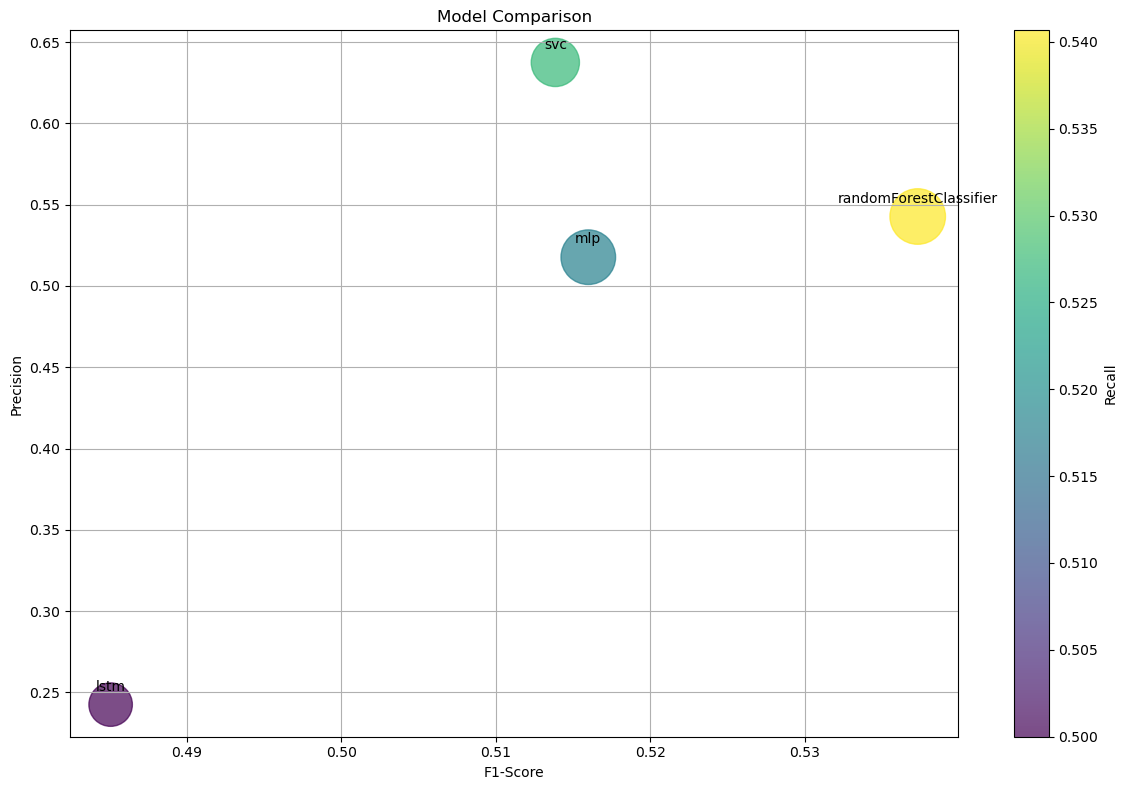

Evaluation: {'auc': 0.5713193638659477, 'f1_score': 0.5330142794214815, 'accuracy': 0.5373134328358209, 'precision': 0.5427239475005379, 'recall': 0.5406593406593406}


In [8]:
# Instantiate predictive models
predictive_models = [PredictiveModel(predictive_model, train_df, val_df, test_df, prefix_length=CONF['prefix_length']) for predictive_model in CONF['predictive_models']]

# Perform hyperparameter optimization
best_candidates, best_model_idx, best_model_model, best_model_config = retrieve_best_model(
    predictive_models,
    max_evaluations=CONF['hyperparameter_optimisation_evaluations'],
    target=CONF['hyperparameter_optimisation_target']
)

# Evaluate best model
best_model = predictive_models[best_model_idx]
best_model.model = best_model_model
best_model.config = best_model_config
print(f'Best model is {best_model.model_type}')

print('Evaluating best model...')
predicted, scores = best_model.predict(test=True)
actual = test_df['label']

initial_result = evaluate_classifier(actual, predicted, scores)
results = evaluate_classifiers(predictive_models,actual)
plot_model_comparison(results)
print(f'Evaluation: {initial_result}')

# Explanation

In [9]:
test_df_correct = test_df[(test_df['label'] == predicted) & (test_df['label'] == 0)]
cf_dataset = pd.concat([train_df, val_df], ignore_index=True)
full_df = pd.concat([train_df, val_df, test_df])
cf_dataset.loc[len(cf_dataset)] = 0

cf_results = explain(CONF, best_model, encoder=encoder, df=full_df.iloc[:, 1:],
        query_instances=test_df_correct.iloc[:, 1:],
        method='genetic_conformance', optimization='baseline',
        heuristic='heuristic_2', support=0.95,
        timestamp_col_name='Complete Timestamp', # name of the timestamp column in the log
        model_path='./experiments/process_models/process_models',
        random_seed=CONF['seed'], adapted=True, filtering=False)

counterfactuals = cf_results.cf_examples_list[0].final_cfs_df.copy()

encoder.decode(counterfactuals)

encoder.decode(test_df_correct)

cf_results.cf_examples_list[0].final_cfs_df = counterfactuals
cf_results.cf_examples_list[0].final_cfs_df_sparse = counterfactuals
cf_results.cf_examples_list[0].test_instance_df = test_df_correct.iloc[:1,1:].copy()


'H' is deprecated and will be removed in a future version, please use 'h' instead.
A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].metho

Computing discovery ...
2024-12-02 11:49:40.056384 experiments randomForestClassifier 0 2 0.50


  0%|                                                                                                                  | 0/1 [00:00<?, ?it/s]Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining 

Computing conformance checking ...
Computing conformance checking ...


  0%|                                                                                                                  | 0/1 [00:01<?, ?it/s]
invalid escape sequence '\['
invalid escape sequence '\['
invalid escape sequence '\['


ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 2 dimension(s) and the array at index 1 has 3 dimension(s)

In [ ]:
print(cf_results.visualize_as_dataframe())

In [ ]:
print(cf_results.visualize_as_dataframe(show_only_changes=True))

In [ ]:
import shap
CONF['explanator'] = ExplainerType.SHAP.value
exp = explain(CONF, best_model, encoder=encoder, test_df=test_df,target_trace=test_df_correct.iloc[0,0])

shap.plots.bar(exp[0])

# Available documentation can be found at: https://rgraziosi-fbk.github.io/nirdizati-light/nirdizati_light.html